In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gym import Env
import gymnasium as gym
from gymnasium import spaces
from gym.spaces import Discrete, Box
import numpy as np
import pygame
import random

In [2]:
class Agent:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.velocities = []
        self.distances = []

    def update_position(self):
        self.position += self.speed

    def update_speed(self, action):
        # 0: slow down, 1: maintain speed, 2: speed up
        if action == 0:
            self.speed = max(0, self.speed - 0.005)
        elif action == 2:
            self.speed = min(1.0, self.speed + 0.005)

class Leader:
    def __init__(self, position, speed, speed_min=0.25, speed_max=1.0, acceleration=0.005):
        self.position = position
        self.leader_speed = speed
        self.leader_speed_min = speed_min
        self.leader_speed_max = speed_max
        self.acceleration = acceleration
        self.velocities = []

        # Target speed the leader will randomly adjust to
        self.leader_target_speed = np.random.uniform(self.leader_speed_min, self.leader_speed_max)

    def update_position(self):
        self.position += self.leader_speed

    def update_speed(self):
        # Adjust speed toward target
        if self.leader_speed < self.leader_target_speed:
            self.leader_speed = min(self.leader_speed + self.acceleration, self.leader_target_speed)
        elif self.leader_speed > self.leader_target_speed:
            self.leader_speed = max(self.leader_speed - self.acceleration, self.leader_target_speed)

        self.velocities.append(self.leader_speed)

        # Assign new target speed once the leader reaches its current target
        if abs(self.leader_speed - self.leader_target_speed) < 0.01:
            self.leader_target_speed = np.random.uniform(self.leader_speed_min, self.leader_speed_max)

class FollowLeaderEnv(gym.Env):
    def __init__(self, num_agents, visualize=False):
        super(FollowLeaderEnv, self).__init__()
        self.num_agents = num_agents

        # Define action space: 0 - slow down, 1 - keep speed, 2 - speed up
        self.action_space = spaces.Discrete(3)

        # Observation space: distance to leader, agent speed, leader speed
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)

        # Initialize leader with a random speed and position
        leader_speed = np.random.uniform(0.25, 1.2)

        # Initialize agents
        self.agents = []
        current_position = 100.0  # Set agents behind the leader
        for i in range(num_agents):
            current_position += random.randint(20, 80)
            self.agents.append(Agent(position=current_position, speed=leader_speed))

        self.leader = Leader(position=current_position+random.randint(20, 80), speed=leader_speed)

        # Target distance to maintain
        self.target_distance = 50.0

        if visualize:
            self.screen = None
            self.clock = None
            self.is_pygame_initialized = False
            self.init_pygame()

    def init_pygame(self):
        print("Initializing Pygame...")
        pygame.init()
        self.screen = pygame.display.set_mode((1000, 300))
        self.clock = pygame.time.Clock()
        self.is_pygame_initialized = True
        pygame.font.init()
        self.font = pygame.font.Font(None, 36)

    def reset(self):
        pass

    def step(self, action, agent_idx):
        agent = self.agents[agent_idx]

        # Determine the leader: if this agent is the last, it follows the overall leader
        if agent_idx == self.num_agents - 1:
            leader = self.leader
        else:
            leader = self.agents[agent_idx + 1]  # Follow the next agent in line

        # Update agent speed based on action
        agent.update_speed(action)
        agent.update_position()

        # Calculate distance to the leader (the one in front)
        distance_to_leader = leader.position - agent.position  # Corrected to use agent's position

        done = False

        # Penalty for being too close or too far from the leader
        if distance_to_leader < 5 or distance_to_leader > 100:
            done = True

        # End simulation if the leader reaches the finish line (position 900)
        if self.leader.position >= 900:
            done = True

        # Observation: distance to leader, agent speed, leader speed
        state = np.array([distance_to_leader, agent.speed, self.leader.leader_speed], dtype=np.float32)

        agent.velocities.append(agent.speed)
        agent.distances.append(distance_to_leader)

        return state, 0, done, {}


    def render(self):
        if not self.is_pygame_initialized:
            return

        self.screen.fill((0, 0, 0))

        # Draw end goal
        pygame.draw.circle(self.screen, (255, 0, 0), (900, 150), 10)

        # Draw the leader
        pygame.draw.circle(self.screen, (0, 0, 255), (int(self.leader.position), 150), 10)

        # Draw the agents
        for agent in self.agents:
            pygame.draw.circle(self.screen, (0, 255, 0), (int(agent.position), 150), 10)

        # Display leader speed
        speed_text = self.font.render(f"Leader Speed: {round(self.leader.leader_speed, 3)}", True, (255, 255, 255))
        self.screen.blit(speed_text, (10, 10))

        pygame.display.flip()
        self.clock.tick(60)

    def close(self):
        if self.is_pygame_initialized:
            print("Closing Pygame...")
            pygame.quit()
            self.is_pygame_initialized = False


In [4]:
# Neural network for Q-learning (DQN)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
import time

# Initialize the environment with visualization
env = FollowLeaderEnv(num_agents=4, visualize=True)  # Assuming you want 5 agents for the example

# Get the state and action dimensions from the environment
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize a new DQN network for testing
dqn_test = DQN(state_dim, action_dim)

# Load the trained model's weights
dqn_test.load_state_dict(torch.load("policy_net_weights_final5.pth"))

# Set the model to evaluation mode 
dqn_test.eval()

# Loop to run the episode
done = False
while not done:
    # Check for pygame events
    for event in pygame.event.get():
        if event.type == pygame.KEYDOWN:
            keys = pygame.key.get_pressed()
            if keys[pygame.K_ESCAPE]:
                done = True
        if event.type == pygame.QUIT:
            done = True

    time.sleep(0.05)  # Add a small delay to slow down the visualization (optional)

    # Loop over each agent to select actions and update their states
    for i in range(len(env.agents)):  # Loop through all agents (no need for '-1')
        agent = env.agents[i]

        # Choose the best action for the agent (exploit, no exploration during testing)
        with torch.no_grad():
            # Using the distance to the next agent/leader and speeds to predict action
            if i == len(env.agents) - 1:  # Last agent following the leader
                action = torch.argmax(dqn_test(torch.FloatTensor([env.leader.position - agent.position, agent.speed, env.leader.leader_speed]))).item()
            else:  # Agents following other agents
                next_agent = env.agents[i + 1]
                action = torch.argmax(dqn_test(torch.FloatTensor([next_agent.position - agent.position, agent.speed, next_agent.speed]))).item()

        # Step the environment with the chosen action
        next_state, reward, done, _ = env.step(action, i)

        if done:
            break

    # Update the leader's position and speed within the same loop
    env.leader.update_position()
    env.leader.update_speed()

    # Render the environment after all updates
    env.render()

# Close the environment when done
env.close()



Initializing Pygame...
Closing Pygame...


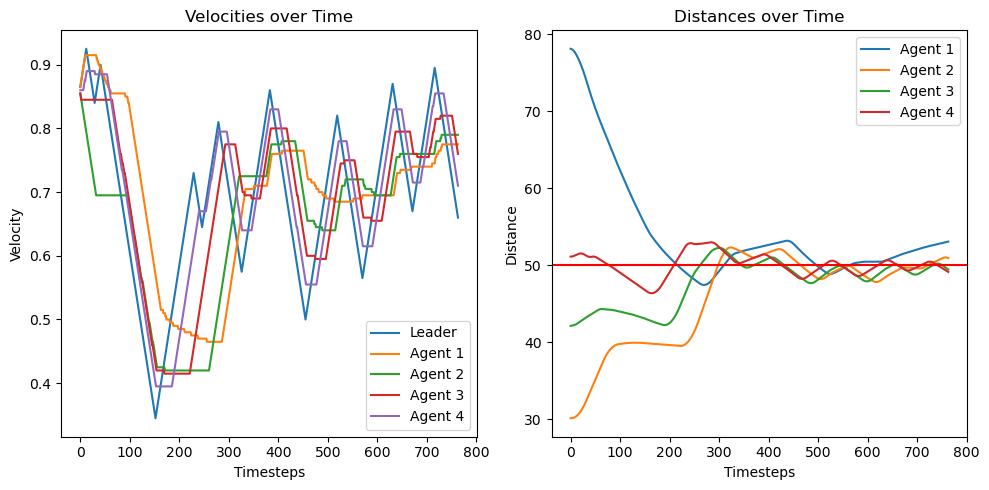

In [6]:
import matplotlib.pyplot as plt

def plot_agent_data(env):
    # Ensure no empty velocity or distance lists for agents
    valid_agents = [agent for agent in env.agents if agent.velocities and agent.distances]

    if not valid_agents:
        print("No valid agent data to plot.")
        return

    # Find the minimum length of velocities/distances across all valid agents
    min_timesteps = min(len(agent.velocities) for agent in valid_agents)
    min_timesteps = min(min_timesteps, len(env.leader.velocities))

    # Plot velocities for each agent
    plt.figure(figsize=(10, 5))
    
    # Plot velocities in one plot
    plt.subplot(1, 2, 1)
    plt.plot(range(min_timesteps), env.leader.velocities[:min_timesteps], label='Leader')
    for i, agent in enumerate(valid_agents):
        plt.plot(range(min_timesteps), agent.velocities[:min_timesteps], label=f'Agent {i+1}')
    plt.title('Velocities over Time')
    plt.xlabel('Timesteps')
    plt.ylabel('Velocity')
    plt.legend()

    # Find the minimum length of distances for all valid agents
    min_timesteps_dist = min(len(agent.distances) for agent in valid_agents)

    # Plot distances (positions) in one plot
    plt.subplot(1, 2, 2)
    for i, agent in enumerate(valid_agents):
        plt.plot(range(min_timesteps_dist), agent.distances[:min_timesteps_dist], label=f'Agent {i+1}')
    plt.title('Distances over Time')
    plt.axhline(y=50, color='r', linestyle='-')
    plt.xlabel('Timesteps')
    plt.ylabel('Distance')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()

# Example usage:
plot_agent_data(env)

